In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import plotly.graph_objs as go
import plotly.io as pio
from matplotlib.colors import ListedColormap, to_rgba

In [6]:
dir_path = '../inteligencia_artificial/train/'
img_size = (224, 224)
X = []
y = []

In [7]:
for file_name in tqdm(os.listdir(dir_path)):
    if file_name.endswith('.jpg'):
        file_path = os.path.join(dir_path, file_name)
        img = imread(file_path)
        img = resize(img, (100, 100))
        X.append(img.flatten())
        y.append(file_name.split("_")[0])

 25%|██▌       | 18900/75501 [10:32<34:03, 27.70it/s]  

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [ ]:
tsne = TSNE(n_components=2, perplexity=120.0, early_exaggeration=6)
X_tsne = tsne.fit_transform(X_pca)

In [ ]:
kmeans = KMeans(n_clusters=120, random_state=42)
labels = kmeans.fit_predict(X_tsne)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
colors = ListedColormap(sns.color_palette("hls", 10).as_hex())

In [ ]:
data = np.hstack((X_tsne, labels.reshape(-1, 1)))

# Criando um dataframe a partir do array
df = pd.DataFrame(data, columns=['x', 'y', 'label'])

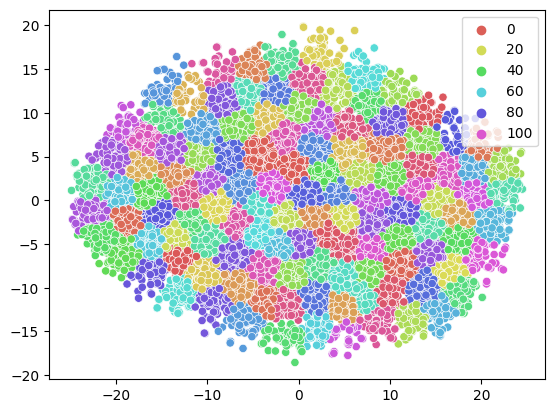

In [ ]:
import seaborn as sns

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='hls')

# Salva a figura em um arquivo PNG
plt.savefig('grafico_seaborn.png')

In [ ]:
centroids = kmeans.cluster_centers_

# Adicione os centróides ao dataframe
centroids_df = pd.DataFrame(centroids, columns=['x', 'y'])
centroids_df['label'] = 'Centroid'

# Concatena os dados dos pontos e dos centróides
plot_data = pd.concat([df, centroids_df])

# Plota o gráfico de dispersão com os pontos e os centróides
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', palette='hls', data=plot_data)
plt.title('Gráfico de Dispersão com Centróides')
plt.savefig('grafico_com_centroides.png')
plt.show()


NameError: name 'kmeans' is not defined